## Importing the CIFAR-100 dataset

In [44]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import LabelBinarizer
# To ignore random tensorflow warnings.
import absl.logging
import matplotlib.pyplot as plt
absl.logging.set_verbosity(absl.logging.ERROR)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


## Data Augmentation

In [45]:
from keras.models import Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

data_augment = Sequential([
    # Commented out when applying to testt data, because it's not deactivated at inference time
    Rescaling(1./255),
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

enc = LabelBinarizer()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

#x_train, y_train = np.concatenate((x_train, x_train), axis=0), np.concatenate((y_train, y_train), axis=0)
#x_train, y_train = np.concatenate((x_train, x_train), axis=0), np.concatenate((y_train, y_train), axis=0)

print(x_train.shape)

(50000, 32, 32, 3)


In [ ]:
# For reference
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
          'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
          'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur',
          'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
          'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
          'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
          'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
          'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
          'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
          'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [36]:
def show_transformed_images(image, grid_size=(3, 3)):
    fig, axes = plt.subplots(*grid_size, figsize=(3*grid_size[0], 3*grid_size[1]))

    image_idx = np.where(image == x_train)[0][0]
    label_idx = 
    axes.ravel()[0].imshow(image)
    axes.ravel()[0].set_xlabel('Original - ' + labels[label_idx])

    for axis in axes.ravel()[1:]:
        axis.imshow(data_augment(image))

    fig.show()

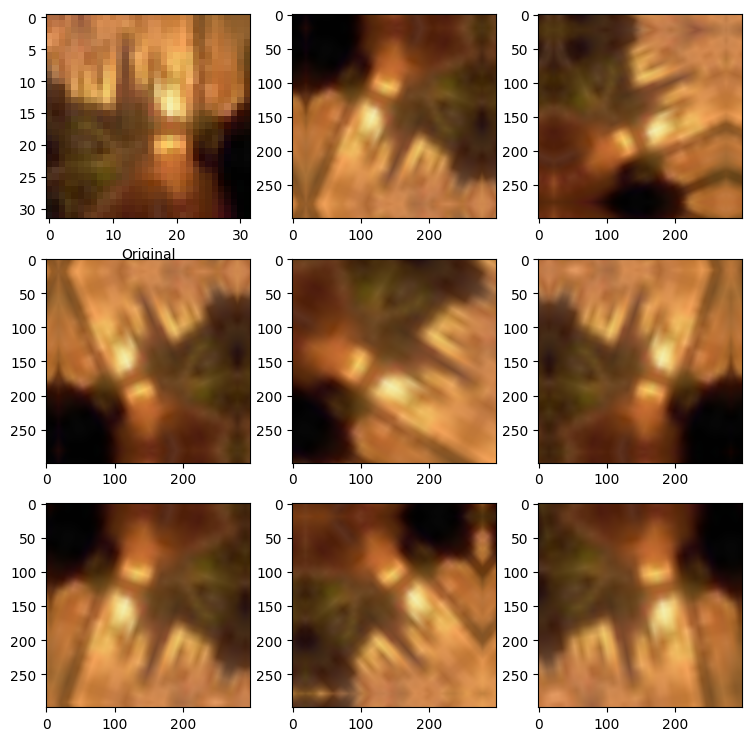

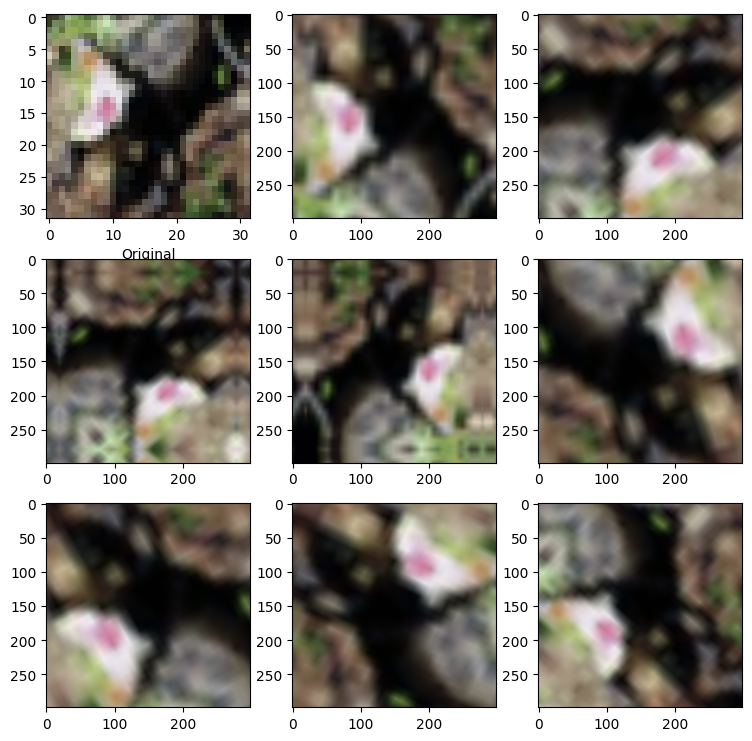

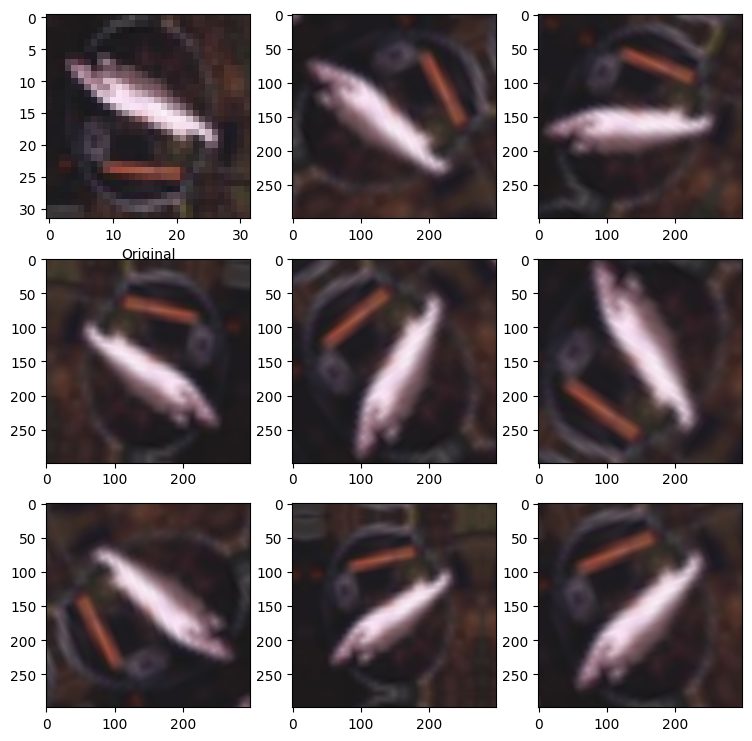

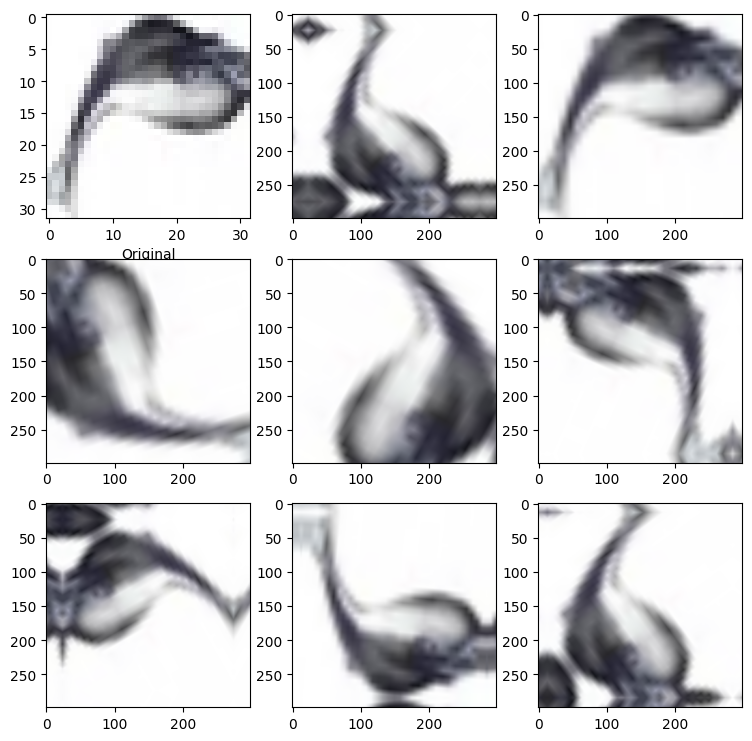

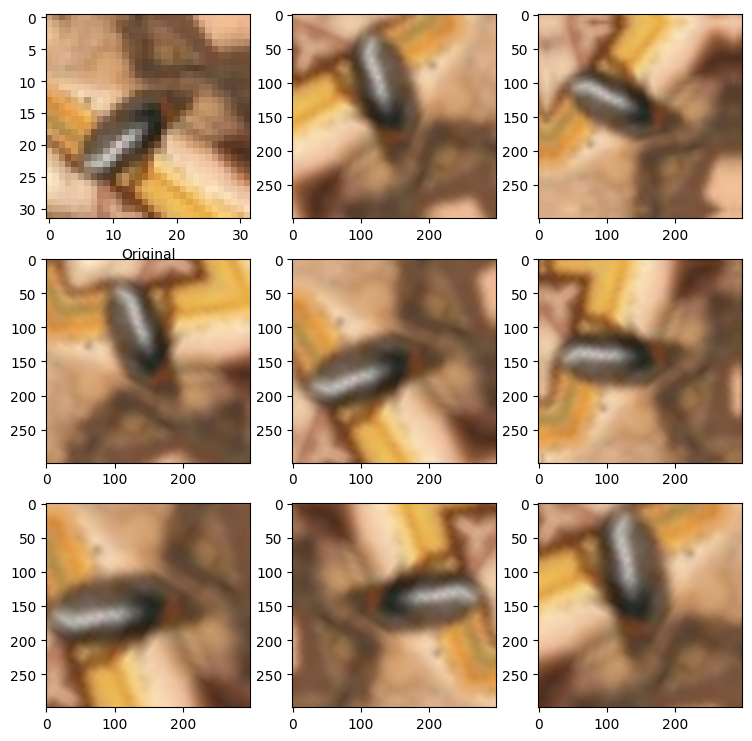

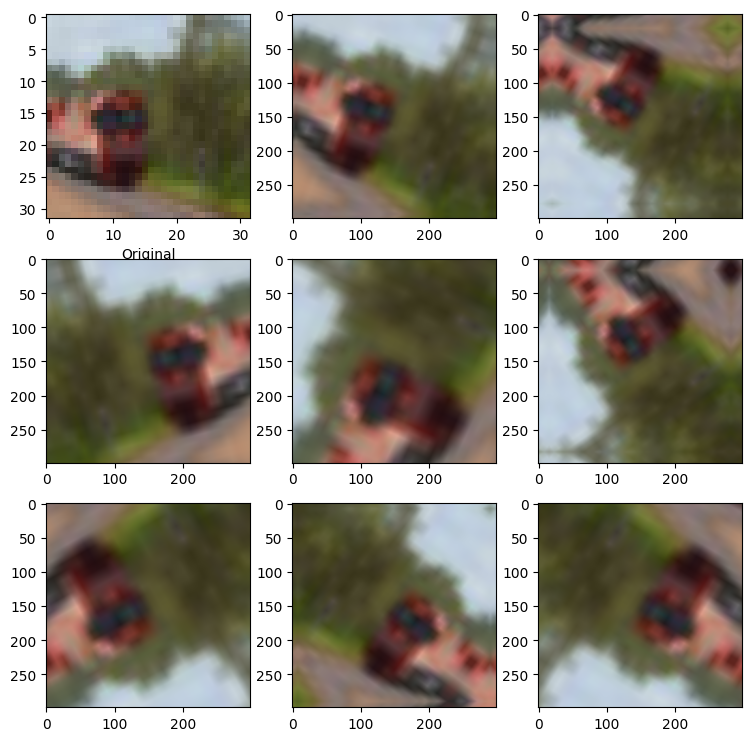

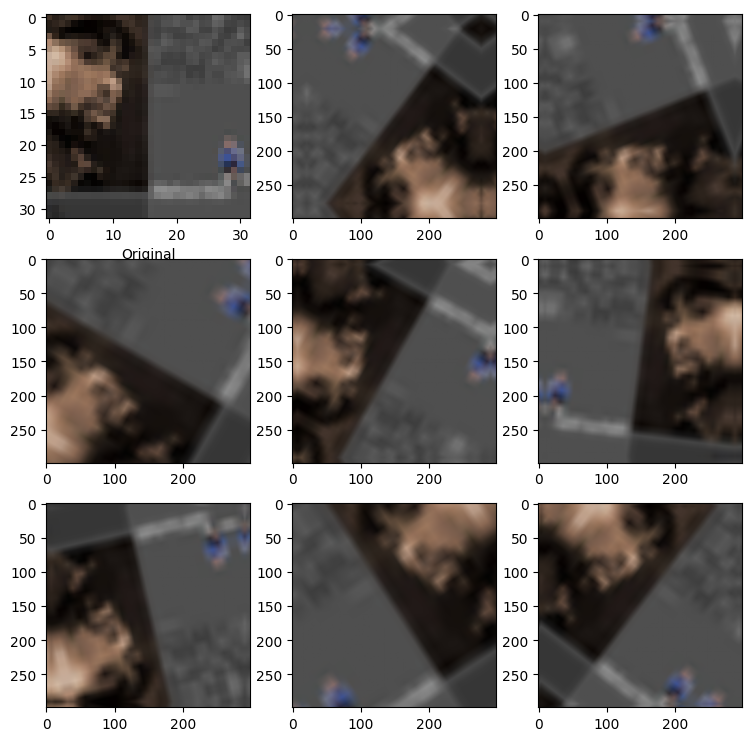

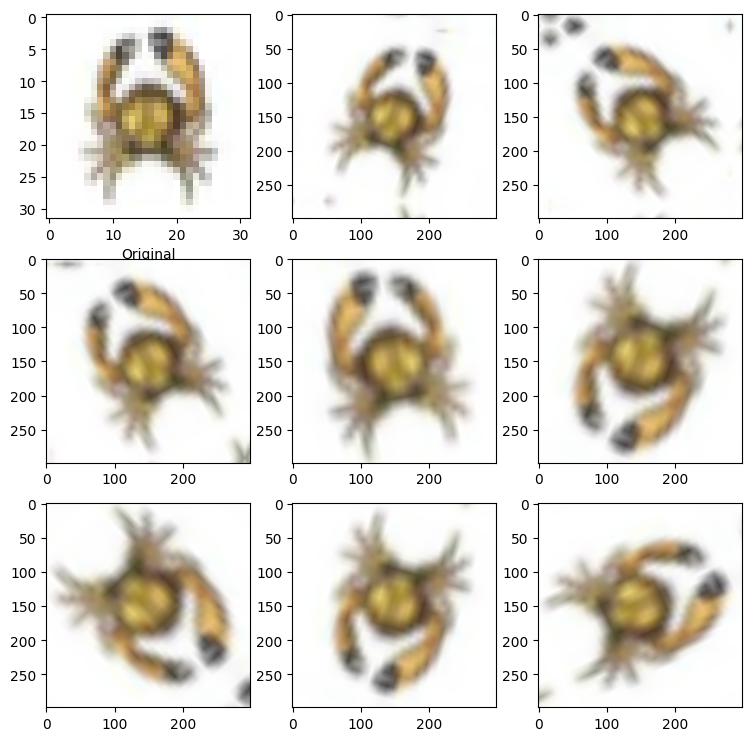

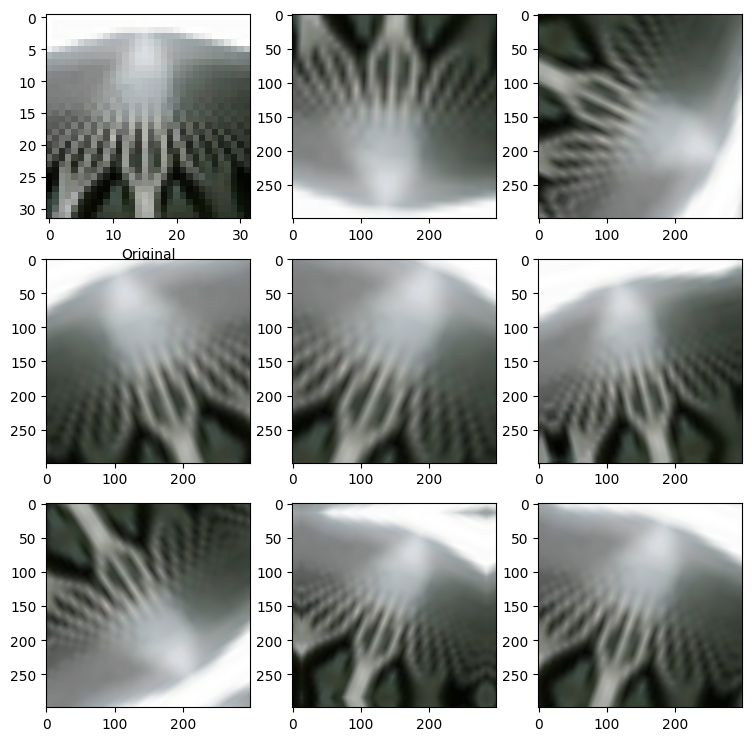

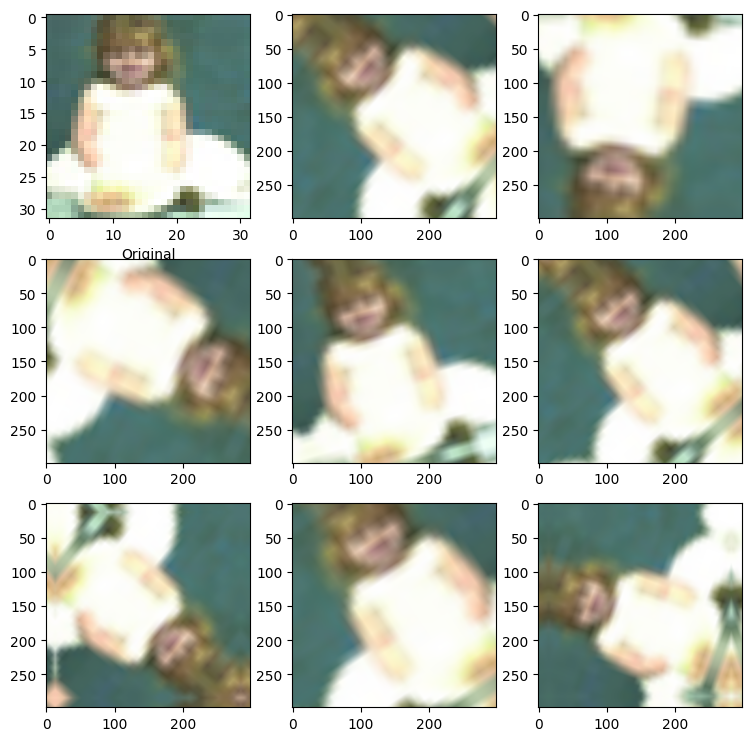

In [42]:
import random

for _ in range(10):
    show_transformed_images(x_train[random.randint(0, 50000)])

In [ ]:
!pip install pyNVML
import pynvml as nvidia_smi

def get_max_batch_size(model, image_size, inference=False):
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    total_gpu_memory = info.total
    # Weights are float32 -> 4 bytes
    model_size = model.count_params() * 4
    # Rescaling layer returns float32
    # RGB channels
    image_bytes = 4 * image_size * image_size * 3
    if inference:
        MAX_BATCH_SIZE = int(np.floor((total_gpu_memory - model_size) / image_bytes))
    else:
        MAX_BATCH_SIZE = int(np.floor(total_gpu_memory / (model_size + image_bytes)))
    MAX_BATCH_SIZE_LOG2 = int(2 ** np.floor(np.log2(MAX_BATCH_SIZE)))
    
    return MAX_BATCH_SIZE, MAX_BATCH_SIZE_LOG2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorboard --logdir ./drive/MyDrive/colab_buffer

In [ ]:
from keras.models import load_model

base_model = load_model('./drive/MyDrive/colab_buffer/myinception-without-aug/fit/20230510-113441/checkpoint')
aug_model = load_model('./drive/MyDrive/colab_buffer/data aug logs/logs/fit/20230423-141037/checkpoint/')
more_aug_model = load_model('./drive/MyDrive/colab_buffer/more-images-data-aug/fit/20230426-160956/checkpoint/')

In [ ]:

def evaluate_certainty(model, n_transforms=10):
    # 10000x100
    base_results = model.predict(x_test, batch_size=get_max_batch_size(model, 32, True)[1])
    # n_transormsx10000x100
    results_after_transform = [base_results]

    for _ in range(n_transforms):
        x_transformed = data_augment(x_test)
        results_after_transform.append(model.predict(x_transformed, batch_size=get_max_batch_size(model, 32, True)[1]))

    results_after_transform = np.array(results_after_transform)
    # 10000x2(#unique, #unique)
    counts = []

    for i in range(len(x_test)):
        elements = results_after_transform[:, i, :]
        counts.append(np.unique(np.argmax(elements, axis=1), return_counts=True, axis=0))

    # 10000x1
    certainties = []

    for i in range(len(counts)):
        idx = np.where(counts[i][0] == np.argmax(base_results[i]))[0][0]
        # + 1 is needed because we also put the base_reults into the results_after_transform list
        certainty = counts[i][1][idx] / (n_transforms + 1)
        certainties.append(certainty)

    overall_certainty = np.mean(certainties)

    return overall_certainty



In [ ]:
get_max_batch_size(base_model, 32, True)

(1308851, 1048576)

In [ ]:
print("Calculating base model certainty")
base_model_certainty = evaluate_certainty(base_model, 100)
print("Calculating aug model certainty")
aug_model_certainty = evaluate_certainty(aug_model, 100)
print("Calculating more aug model certainty")
more_aug_model_certainty = evaluate_certainty(more_aug_model, 100)

print(f'Base model certainty: {round(base_model_certainty * 100, 2)}%')
print(f'Model certainty with augmentation: {round(aug_model_certainty * 100, 2)}%')
print(f'Model certainty with multiplied data and augmentation: {round(more_aug_model_certainty * 100, 2)}%')